In [107]:
import xarray as xr

In [108]:
pwd

'/home/jovyan/Tjaernoe2022-group1_2nd/notebooks/Ingvild'

In [124]:
data1 = xr.open_dataset('/home/jovyan/Data/zeppelin-cloud-aerosol-1_part1.nc4')
data2 = xr.open_dataset('/home/jovyan/Data/zeppelin-cloud-aerosol-1_part2.nc4')

In [125]:
data1

<xarray.Dataset>
Dimensions:                                        (time: 83755,
                                                    aerosol_diameters: 30,
                                                    cloud_diameters: 43,
                                                    boundaries: 2,
                                                    target_classification: 11)
Coordinates:
  * time                                           (time) datetime64[ns] 2015...
  * aerosol_diameters                              (aerosol_diameters) float64 ...
  * cloud_diameters                                (cloud_diameters) float64 ...
  * boundaries                                     (boundaries) object 'left'...
  * target_classification                          (target_classification) object ...
Data variables: (12/17)
    aerosol_particle_size_distribution             (time, aerosol_diameters) float64 ...
    total_aerosol_particle_concentration           (time) float64 ...
    cloud_flag                                     (time) object ...
    enrichment_factor                              (time) float64 ...
    transmission_efficiency_factor                 (time) float64 ...
    cluster                                        (time) float64 ...
    ...                                             ...
    temperature                                    (time) float64 ...
    wind_direction                                 (time) float64 ...
    wind_speed                                     (time) float64 ...
    updraft_velocity                               (time) float64 ...
    time_bounds                                    (time, boundaries) datetime64[ns] ...
    normalised_target_classification               (time, target_classification) float64 ...
Attributes:
    title:       Cloud and aerosol measurements from Zeppelin Observatory, Sv...
    authors:     Linn Karlsson, Paul Zieger, Radovan Krejci, Makoto Koike, Ke...
    contact:     Paul Zieger, paul.zieger@aces.su.se
    site:        Zeppelin Observatory, Svalbard, 78.9N 11.9E
    comment:     This is one of two files that together contain all data that...
    start_date:  2015-11-27
    end_date:    2018-02-04
    version:     1.0
    history:     2021-05-06 created

In [126]:
data1_cl_mask=data1.where(data1['cloud_flag']=='yes')

In [127]:
data1_cl_mask

<xarray.Dataset>
Dimensions:                                        (time: 83755,
                                                    aerosol_diameters: 30,
                                                    cloud_diameters: 43,
                                                    boundaries: 2,
                                                    target_classification: 11)
Coordinates:
  * time                                           (time) datetime64[ns] 2015...
  * aerosol_diameters                              (aerosol_diameters) float64 ...
  * cloud_diameters                                (cloud_diameters) float64 ...
  * boundaries                                     (boundaries) object 'left'...
  * target_classification                          (target_classification) object ...
Data variables: (12/17)
    aerosol_particle_size_distribution             (time, aerosol_diameters) float64 ...
    total_aerosol_particle_concentration           (time) float64 29.39 ... nan
    cloud_flag                                     (time) object 'yes' ... nan
    enrichment_factor                              (time) float64 10.82 ... nan
    transmission_efficiency_factor                 (time) float64 2.796 ... nan
    cluster                                        (time) float64 2.0 ... nan
    ...                                             ...
    temperature                                    (time) float64 -6.659 ... nan
    wind_direction                                 (time) float64 130.2 ... nan
    wind_speed                                     (time) float64 9.748 ... nan
    updraft_velocity                               (time) float64 4.506 ... nan
    time_bounds                                    (time, boundaries) datetime64[ns] ...
    normalised_target_classification               (time, target_classification) float64 ...
Attributes:
    title:       Cloud and aerosol measurements from Zeppelin Observatory, Sv...
    authors:     Linn Karlsson, Paul Zieger, Radovan Krejci, Makoto Koike, Ke...
    contact:     Paul Zieger, paul.zieger@aces.su.se
    site:        Zeppelin Observatory, Svalbard, 78.9N 11.9E
    comment:     This is one of two files that together contain all data that...
    start_date:  2015-11-27
    end_date:    2018-02-04
    version:     1.0
    history:     2021-05-06 created

In [83]:
import xarray as xr
import numpy as np
def pnsd_integration(ds, size_thresh, var='dNdlogD', dvar = 'D', unit_diameter='m'):
    '''
    - D is the mean diameter of the size bins
    - time is the time dimension
    - ds is the dataset containing the size distribution
    - pnsd is the variable in which the particle number size distribution is stored (dN/dlogDp)
    - size_thresh is the lower limit of the size bins to be integrated in nanometers
    '''
    if unit_diameter=='m':
        size_thresh_unit = size_thresh*1e-9
    elif unit_diameter=='um':
        size_thresh_unit = size_thresh*1e-6
    else:
        size_thresh_unit=size_thresh
    Dp = ds[dvar].values
    logDp = np.log10(Dp)
    interval = np.array([logDp[i]-logDp[i-1] for i in range(1,np.size(Dp))])/2
    centers = logDp[:-1]+interval
    centers_bis = np.append(logDp[0]-interval[0], centers)
    centers_bis = np.append(centers_bis, logDp[-1]+interval[-1])
    bound_bin = 10**(centers_bis)#*10**(-9)
    dlogDp = np.array([np.log10(bound_bin[i+1])-np.log10(bound_bin[i]) for i in range(0, bound_bin.shape[0]-1)])
    pnsd_nolog = np.zeros(ds[var].values.shape)
    for i, Dp_i in enumerate(Dp):
        pnsd_nolog[:,i] = ds[var].sel(**{dvar : Dp_i}).values * dlogDp[i]
    ds[f'{var}_unlog'] = (['time', dvar], pnsd_nolog)
    out = ds[f'{var}_unlog'].sel(**{dvar:slice(size_thresh_unit, 10000000)}).sum(**{'dim':dvar})
    return out


In [71]:
data1

<xarray.Dataset>
Dimensions:                                        (time: 83755,
                                                    aerosol_diameters: 30,
                                                    cloud_diameters: 43,
                                                    boundaries: 2,
                                                    target_classification: 11)
Coordinates:
  * time                                           (time) datetime64[ns] 2015...
  * aerosol_diameters                              (aerosol_diameters) float64 ...
  * cloud_diameters                                (cloud_diameters) float64 ...
  * boundaries                                     (boundaries) object 'left'...
  * target_classification                          (target_classification) object ...
Data variables: (12/20)
    aerosol_particle_size_distribution             (time, aerosol_diameters) float64 ...
    total_aerosol_particle_concentration           (time) float64 29.39 ... 2...
    cloud_flag                                     (time) object 'yes' ... 'no'
    enrichment_factor                              (time) float64 10.82 ... 1.0
    transmission_efficiency_factor                 (time) float64 2.796 ... nan
    cluster                                        (time) float64 2.0 ... nan
    ...                                             ...
    updraft_velocity                               (time) float64 4.506 ... 4...
    time_bounds                                    (time, boundaries) datetime64[ns] ...
    normalised_target_classification               (time, target_classification) float64 ...
    cloud_particle_size_distribution_unlog         (time, cloud_diameters) float64 ...
    N1                                             (time) float64 2.109 ... 0.0
    N0.0                                           (time) float64 2.109 ... 0.0
Attributes:
    title:       Cloud and aerosol measurements from Zeppelin Observatory, Sv...
    authors:     Linn Karlsson, Paul Zieger, Radovan Krejci, Makoto Koike, Ke...
    contact:     Paul Zieger, paul.zieger@aces.su.se
    site:        Zeppelin Observatory, Svalbard, 78.9N 11.9E
    comment:     This is one of two files that together contain all data that...
    start_date:  2015-11-27
    end_date:    2018-02-04
    version:     1.0
    history:     2021-05-06 created

In [84]:
data1['N1_cloud']= pnsd_integration(data1, 1, var='cloud_particle_size_distribution',dvar='cloud_diameters')

In [85]:
cpsd1_months = data1['N1_cloud'].groupby('time.month').mean(keep_attrs=True)

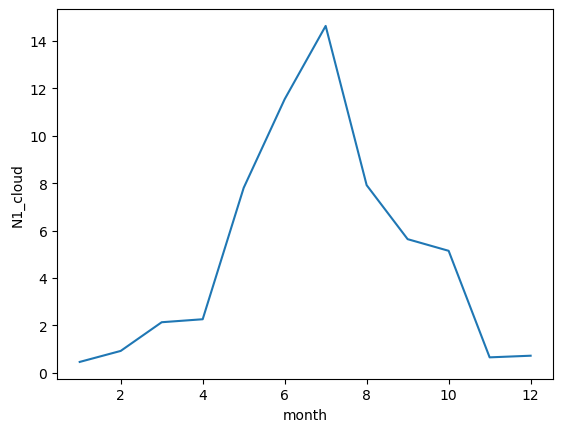

In [86]:
cpsd1_months.plot()

In [172]:
data1_cl_mask=data1.where(data1['cloud_flag']=='yes')

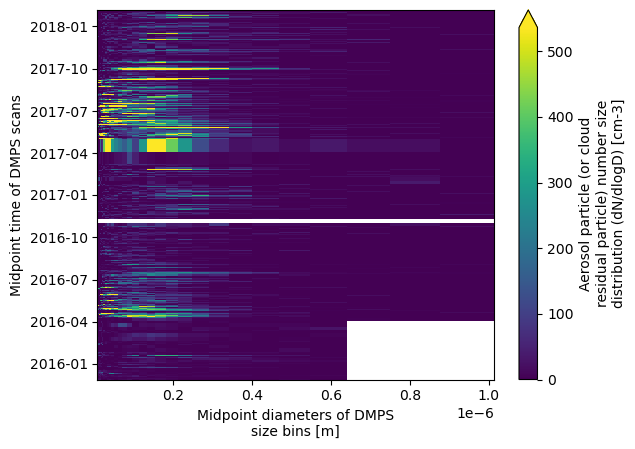

In [173]:
data1['aerosol_particle_size_distribution'].plot(robust=True)

In [177]:
data1

<xarray.Dataset>
Dimensions:                                        (time: 83755,
                                                    aerosol_diameters: 30,
                                                    cloud_diameters: 43,
                                                    boundaries: 2,
                                                    target_classification: 11)
Coordinates:
  * time                                           (time) datetime64[ns] 2015...
  * aerosol_diameters                              (aerosol_diameters) float64 ...
  * cloud_diameters                                (cloud_diameters) float64 ...
  * boundaries                                     (boundaries) object 'left'...
  * target_classification                          (target_classification) object ...
Data variables: (12/19)
    aerosol_particle_size_distribution             (time, aerosol_diameters) float64 ...
    total_aerosol_particle_concentration           (time) float64 29.39 ... 2...
    cloud_flag                                     (time) object 'yes' ... 'no'
    enrichment_factor                              (time) float64 10.82 ... 1.0
    transmission_efficiency_factor                 (time) float64 2.796 ... nan
    cluster                                        (time) float64 2.0 ... nan
    ...                                             ...
    wind_speed                                     (time) float64 9.748 ... 1...
    updraft_velocity                               (time) float64 4.506 ... 4...
    time_bounds                                    (time, boundaries) datetime64[ns] ...
    normalised_target_classification               (time, target_classification) float64 ...
    aerosol_particle_size_distribution_unlog       (time, aerosol_diameters) float64 ...
    N1_aerosol                                     (time) float64 52.04 ... 14.2
Attributes:
    title:       Cloud and aerosol measurements from Zeppelin Observatory, Sv...
    authors:     Linn Karlsson, Paul Zieger, Radovan Krejci, Makoto Koike, Ke...
    contact:     Paul Zieger, paul.zieger@aces.su.se
    site:        Zeppelin Observatory, Svalbard, 78.9N 11.9E
    comment:     This is one of two files that together contain all data that...
    start_date:  2015-11-27
    end_date:    2018-02-04
    version:     1.0
    history:     2021-05-06 created

In [174]:
data1_cl_mask['N1_aerosol']=pnsd_integration(data1, 1, var='aerosol_particle_size_distribution',dvar='aerosol_diameters')

In [175]:
apsd1_months=data1_cl_mask['N1_aerosol'].groupby('time.month').mean(keep_attrs=True)

In [176]:
tapc1_months=data1_cl_mask['total_aerosol_particle_concentration'].groupby('time.month').mean(keep_attrs=True)

In [169]:
import matplotlib.pyplot as plt

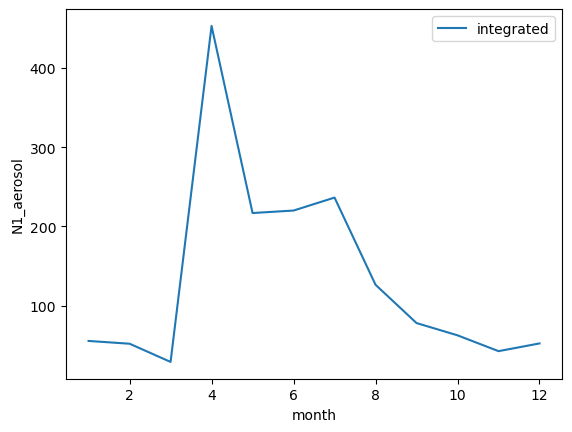

In [171]:
apsd1_months.plot(label='integrated')
#tapc1_months.plot(label='tot')
plt.legend()

In [105]:
data1.total_aerosol_particle_concentration

<xarray.DataArray 'total_aerosol_particle_concentration' (time: 83755)>
array([29.388072, 11.876519, 11.538748, ..., 23.106667, 24.12    , 26.626667])
Coordinates:
  * time     (time) datetime64[ns] 2015-11-27T08:23:25 ... 2018-02-04T23:58:14
Attributes:
    long_name:   Aerosol particle (or cloud residual particle) number concent...
    instrument:  Condensation particle counter
    units:       cm-3
    history:     Where cloud sampling occurred (ie the GCVI was running, see ...

In [82]:
pnsd_integration(data1, 1, var='aerosol_particle_size_distribution',dvar='aerosol_diameters')

In [36]:
#from sizedist_utils import pnsd_integration

In [23]:
time='hoho'

di = dict(time='hallo', abc='haha')

In [30]:
di = dict(yscale='log',xscale='log')

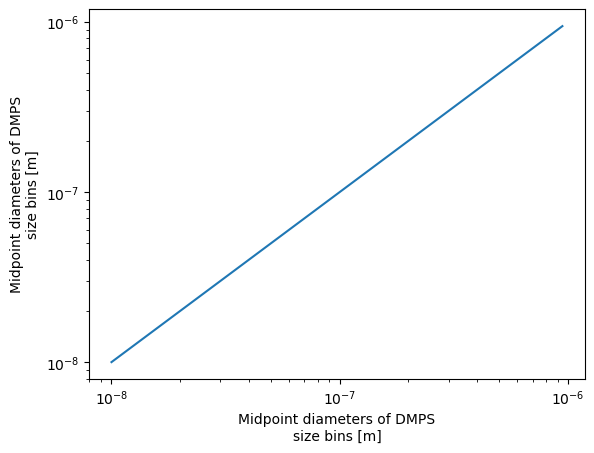

In [31]:
data1['aerosol_diameters'].plot(**di)

In [29]:
time

'hoho'

In [21]:

{abc:'hallo'}

NameError: name 'abc' is not defined

In [15]:
di['time']

'hallo'

In [ ]:
ds.sel({time=dfse)

In [55]:
pnsd_integration(data1, 1, var='cloud_particle_size_distribution',dvar='cloud_diameters')

In [56]:
data1#['N1']

<xarray.Dataset>
Dimensions:                                        (time: 83755,
                                                    aerosol_diameters: 30,
                                                    cloud_diameters: 43,
                                                    boundaries: 2,
                                                    target_classification: 11)
Coordinates:
  * time                                           (time) datetime64[ns] 2015...
  * aerosol_diameters                              (aerosol_diameters) float64 ...
  * cloud_diameters                                (cloud_diameters) float64 ...
  * boundaries                                     (boundaries) object 'left'...
  * target_classification                          (target_classification) object ...
Data variables: (12/20)
    aerosol_particle_size_distribution             (time, aerosol_diameters) float64 ...
    total_aerosol_particle_concentration           (time) float64 29.39 ... 2...
    cloud_flag                                     (time) object 'yes' ... 'no'
    enrichment_factor                              (time) float64 10.82 ... 1.0
    transmission_efficiency_factor                 (time) float64 2.796 ... nan
    cluster                                        (time) float64 2.0 ... nan
    ...                                             ...
    updraft_velocity                               (time) float64 4.506 ... 4...
    time_bounds                                    (time, boundaries) datetime64[ns] ...
    normalised_target_classification               (time, target_classification) float64 ...
    cloud_particle_size_distribution_unlog         (time, cloud_diameters) float64 ...
    N1                                             (time) float64 2.109 ... 0.0
    N0.0                                           (time) float64 2.109 ... 0.0
Attributes:
    title:       Cloud and aerosol measurements from Zeppelin Observatory, Sv...
    authors:     Linn Karlsson, Paul Zieger, Radovan Krejci, Makoto Koike, Ke...
    contact:     Paul Zieger, paul.zieger@aces.su.se
    site:        Zeppelin Observatory, Svalbard, 78.9N 11.9E
    comment:     This is one of two files that together contain all data that...
    start_date:  2015-11-27
    end_date:    2018-02-04
    version:     1.0
    history:     2021-05-06 created

In [37]:
month = data1['time.month']

In [38]:
month

<xarray.DataArray 'month' (time: 83755)>
array([11, 11, 11, ...,  2,  2,  2])
Coordinates:
  * time     (time) datetime64[ns] 2015-11-27T08:23:25 ... 2018-02-04T23:58:14

In [22]:
data1.cloud_particle_size_distribution

<xarray.DataArray 'cloud_particle_size_distribution' (time: 83755,
                                                      cloud_diameters: 43)>
array([[1.896982, 3.082426, 2.778608, ..., 1.599814, 1.766618, 2.131093],
       [0.83001 , 1.258907, 1.100554, ..., 0.884721, 0.61791 , 1.015153],
       [0.823218, 0.858281, 0.982679, ..., 0.605335, 0.543575, 0.99451 ],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]])
Coordinates:
  * time             (time) datetime64[ns] 2015-11-27T08:23:25 ... 2018-02-04...
  * cloud_diameters  (cloud_diameters) float64 3.464e-06 4.472e-06 ... 4.599e-05
Attributes:
    long_name:   Cloud particle number size distribution (dN/dlogD)
    instrument:  Fog monitor (FM-120, DMT)
    units:       cm-3
    contact:     Makoto Koike, University of Tokyo
    history:     Averaged (mean) from 10s time resolution down to DMPS time r...

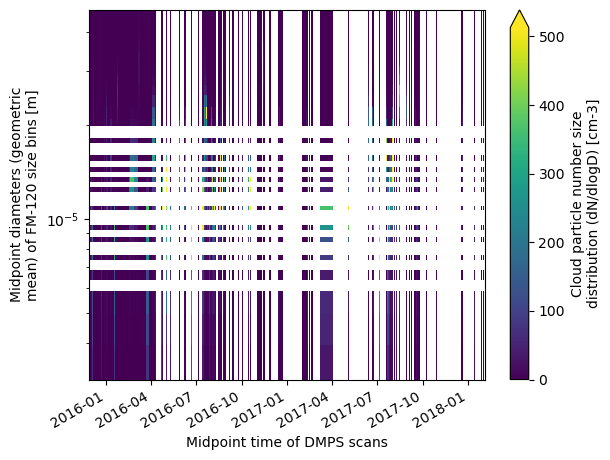

In [35]:
data1['cloud_particle_size_distribution'].plot(x='time', yscale='log', robust=True)

In [36]:
data1['cloud_particle_size_distribution']

<xarray.DataArray 'cloud_particle_size_distribution' (time: 83755,
                                                      cloud_diameters: 43)>
array([[1.896982, 3.082426, 2.778608, ..., 1.599814, 1.766618, 2.131093],
       [0.83001 , 1.258907, 1.100554, ..., 0.884721, 0.61791 , 1.015153],
       [0.823218, 0.858281, 0.982679, ..., 0.605335, 0.543575, 0.99451 ],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]])
Coordinates:
  * time             (time) datetime64[ns] 2015-11-27T08:23:25 ... 2018-02-04...
  * cloud_diameters  (cloud_diameters) float64 3.464e-06 4.472e-06 ... 4.599e-05
Attributes:
    long_name:   Cloud particle number size distribution (dN/dlogD)
    instrument:  Fog monitor (FM-120, DMT)
    units:       cm-3
    contact:     Makoto Koike, University of Tokyo
    history:     Averaged (mean) from 10s time resolution down to DMPS time r...

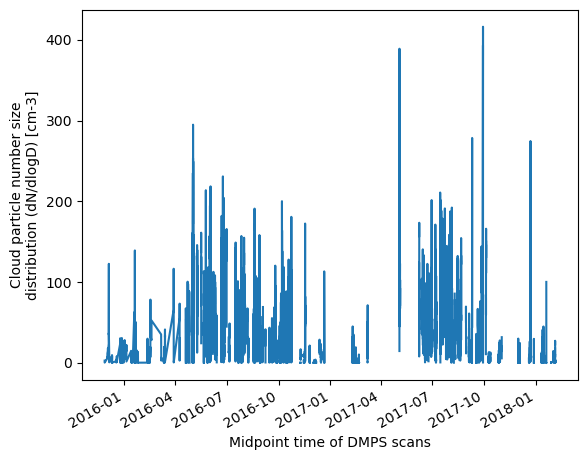

In [24]:
data1['cloud_particle_size_distribution'].mean('cloud_diameters', keep_attrs=True).plot(x ='time')

In [22]:
apsd1_months = data1['aerosol_particle_size_distribution'].groupby('time.month').mean(keep_attrs=True)

In [57]:
cpsd1_months = data1['N1'].groupby('time.month').mean(keep_attrs=True)

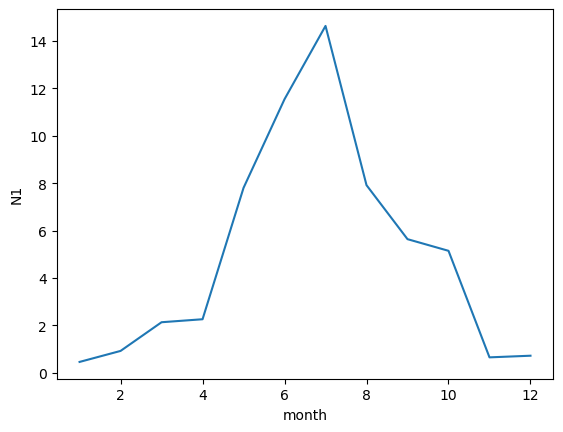

In [58]:
cpsd1_months.plot()

In [41]:
cpsd1_months

<xarray.DataArray 'N1' (month: 12)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

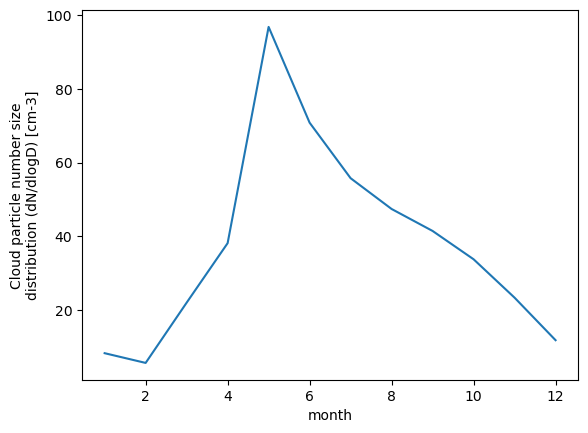

In [29]:
cpsd1_months.mean('cloud_diameters', keep_attrs=True).plot(x ='month', add_legend=True)
#apsd1_months.mean('aerosol_diameters',keep_attrs=True).plot(x = 'month', add_legend=True)

In [66]:
import numpy as np

In [67]:
np.log10(cpsd1_months.cloud_diameters.isel(cloud_diameters=slice(1,None)).values)-np.log10(cpsd1_months).cloud_diameters.isel(cloud_diameters=slice(0,-1)).values


array([-5.34948847, -5.26144384, -5.20256593, -5.18838163, -5.13878957,
       -5.12591325, -5.10787123, -5.07743355, -5.07134212, -5.04601433,
       -5.02288774, -5.01507234, -4.98411573, -4.96041975, -4.95315827,
       -4.92220512, -4.90344966, -4.88980614, -4.86997719, -4.85884888,
       -4.83890419, -4.8293189 , -4.79674472, -4.79406549, -4.76548251,
       -4.7454159 , -4.73261309, -4.70260377, -4.69953339, -4.65804641,
       -4.62018805, -4.58537209, -4.5531451 , -4.52314814, -4.49509217,
       -4.46874099, -4.4438991 , -4.42040282, -4.39811375, -4.37691383,
       -4.3567015 , -4.3373888 ])

In [5]:
data1#['aerosol_particle_size_distribution']

<xarray.Dataset>
Dimensions:                                        (time: 83755,
                                                    aerosol_diameters: 30,
                                                    cloud_diameters: 43,
                                                    boundaries: 2,
                                                    target_classification: 11)
Coordinates:
  * time                                           (time) datetime64[ns] 2015...
  * aerosol_diameters                              (aerosol_diameters) float64 ...
  * cloud_diameters                                (cloud_diameters) float64 ...
  * boundaries                                     (boundaries) object 'left'...
  * target_classification                          (target_classification) object ...
Data variables: (12/17)
    aerosol_particle_size_distribution             (time, aerosol_diameters) float64 ...
    total_aerosol_particle_concentration           (time) float64 ...
    cloud_flag                                     (time) object ...
    enrichment_factor                              (time) float64 ...
    transmission_efficiency_factor                 (time) float64 ...
    cluster                                        (time) float64 ...
    ...                                             ...
    temperature                                    (time) float64 ...
    wind_direction                                 (time) float64 ...
    wind_speed                                     (time) float64 ...
    updraft_velocity                               (time) float64 ...
    time_bounds                                    (time, boundaries) datetime64[ns] ...
    normalised_target_classification               (time, target_classification) float64 ...
Attributes:
    title:       Cloud and aerosol measurements from Zeppelin Observatory, Sv...
    authors:     Linn Karlsson, Paul Zieger, Radovan Krejci, Makoto Koike, Ke...
    contact:     Paul Zieger, paul.zieger@aces.su.se
    site:        Zeppelin Observatory, Svalbard, 78.9N 11.9E
    comment:     This is one of two files that together contain all data that...
    start_date:  2015-11-27
    end_date:    2018-02-04
    version:     1.0
    history:     2021-05-06 created

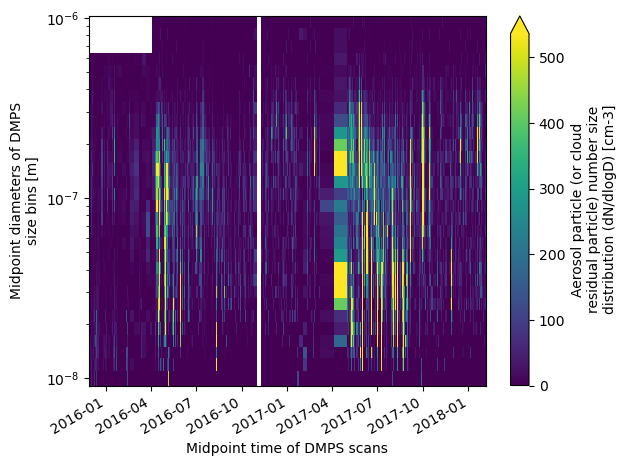

In [19]:
data1['aerosol_particle_size_distribution'].plot(x ='time', robust=True, yscale='log')

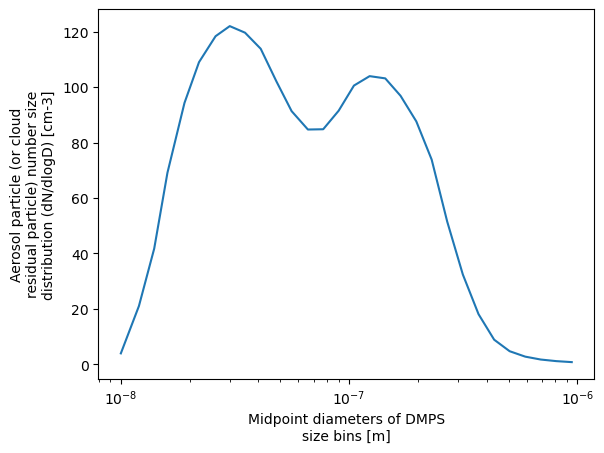

In [23]:
data1['aerosol_particle_size_distribution'].mean('time', keep_attrs=True).plot(xscale='log')#x ='time', robust=True, yscale='log')

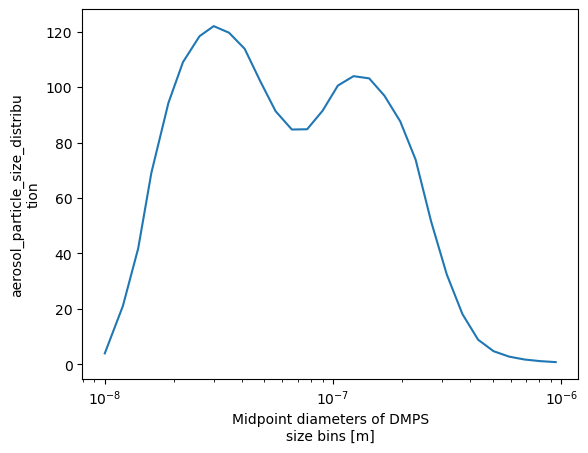

In [24]:
data1['aerosol_particle_size_distribution'].mean('time').plot(xscale='log')

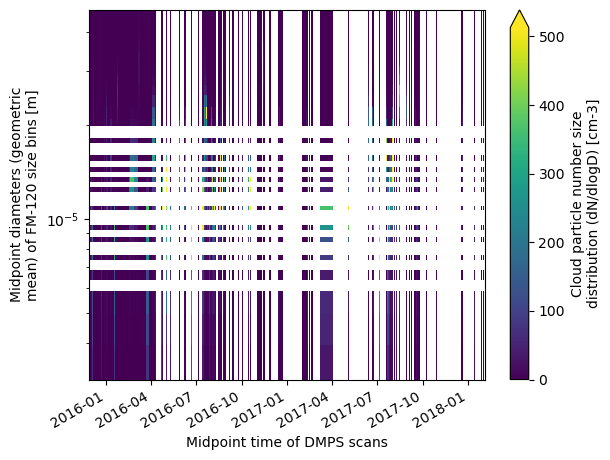

In [17]:
data1['cloud_particle_size_distribution'].plot(x='time', yscale='log', robust=True)